## Notebook to create embedding from pre-trained [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) model

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from scipy import spatial
from torchinfo import summary

/export/home/co21btech11001/.conda/envs/nlp_env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load Data and Model

In [3]:
df_ques_url = pd.read_pickle('../../data/questions_relevant_urls.pkl')
print(df_ques_url.shape)
df_ques_url.head(3)

(36925, 2)


,question,relevant_docs_urls
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...


In [4]:
df_doc_content = pd.read_pickle('../../data/docs_url_content.pkl')
print(df_doc_content.shape)
df_doc_content.head(3)

(7873, 2)


,document_url,document_content
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,Keratoderma with woolly hair: MedlinePlus Gene...
1,https://ghr.nlm.nih.gov/condition/kniest-dyspl...,Kniest dysplasia: MedlinePlus Genetics\nSkip n...
2,https://ghr.nlm.nih.gov/condition/leukoencepha...,Leukoencephalopathy with vanishing white matte...


In [5]:
# A histogram of len of relevant_docs_urls
num_rel_docs = df_ques_url['relevant_docs_urls'].apply(len)
num_rel_docs.value_counts()

relevant_docs_urls
1    36526
2      375
3       23
4        1
Name: count, dtype: int64

In [6]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
model = SentenceTransformer(model_name)
model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
summary(model)

Layer (type:depth-idx)                                       Param #
SentenceTransformer                                          --
├─Transformer: 1-1                                           --
│    └─MPNetModel: 2-1                                       --
│    │    └─MPNetEmbeddings: 3-1                             23,841,024
│    │    └─MPNetEncoder: 3-2                                85,054,848
│    │    └─MPNetPooler: 3-3                                 590,592
├─Pooling: 1-2                                               --
Total params: 109,486,464
Trainable params: 109,486,464
Non-trainable params: 0

In [8]:
model.get_max_seq_length()

512

## Analyze the number of tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (2472 > 512). Running this sequence through the model will result in indexing errors


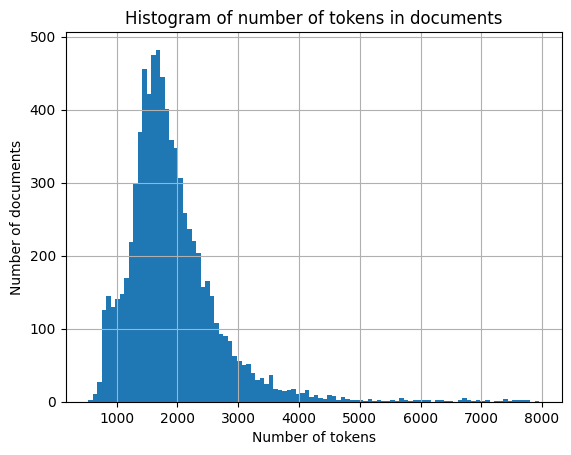

In [9]:
# Plot a histogram of the number of tokens in the documents
doc_lengths = df_doc_content['document_content'].apply(lambda x: len(tokenizer.encode(x)))
plt.hist(doc_lengths, bins=100)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.title('Histogram of number of tokens in documents')
plt.grid()
plt.show()

In [10]:
# Print min, max, mean, median number of tokens in the documents
print(f"Min number of tokens in the documents: {doc_lengths.min()}")
print(f"Max number of tokens in the documents: {doc_lengths.max()}")
print(f"Mean number of tokens in the documents: {doc_lengths.mean()}")
print(f"Median number of tokens in the documents: {doc_lengths.median()}")
print(f"99th percentile number of tokens in the documents: {doc_lengths.quantile(0.99)}")

Min number of tokens in the documents: 531
Max number of tokens in the documents: 7952
Mean number of tokens in the documents: 1918.5365172107201
Median number of tokens in the documents: 1770.0
99th percentile number of tokens in the documents: 4775.799999999997


## Create chunks

In [11]:
from langchain_text_splitters import SentenceTransformersTokenTextSplitter

In [12]:
text_splitter = SentenceTransformersTokenTextSplitter(
    model_name=model_name,
    chunk_overlap  = 5
)

In [15]:
tqdm.pandas()

In [16]:
df_doc_content['document_chunks'] = df_doc_content['document_content'].progress_apply(
    lambda x: text_splitter.split_text(x)
)

100%|██████████| 7873/7873 [01:28<00:00, 88.52it/s] 


In [17]:
df_doc_content.to_pickle('../../data/docs_url_content_chunks.pkl')

In [18]:
# Number of chunks
num_chunks = df_doc_content['document_chunks'].apply(len)
num_chunks.value_counts()

document_chunks
4     2855
3     1897
5     1461
6      623
2      519
7      258
8      107
9       58
10      25
12      16
14      15
11      14
15      10
13       9
16       6
Name: count, dtype: int64

In [19]:
print("Total chunks:", num_chunks.sum())
print("Total documents:", len(df_doc_content))
print(f"Average number of chunks per document: {num_chunks.mean()}")
print(f"Median number of chunks per document: {num_chunks.median()}")
print(f"Max number of chunks per document: {num_chunks.max()}")
print(f"99th percentile number of chunks per document: {num_chunks.quantile(0.99)}")
print(f"Min number of chunks per document: {num_chunks.min()}")

Total chunks: 33545
Total documents: 7873
Average number of chunks per document: 4.260764638638384
Median number of chunks per document: 4.0
Max number of chunks per document: 16
99th percentile number of chunks per document: 10.0
Min number of chunks per document: 2


### Store `len(relevant_chunks)` in `df_ques_url`

In [28]:
def find_num_chunks(urls):
    num_chunks = 0
    for url in urls:
        df_temp = df_doc_content[df_doc_content['document_url'] == url]
        num_chunks += len(df_temp['document_chunks'].values[0])
    return num_chunks

df_ques_url['num_rel_chunks'] = df_ques_url['relevant_docs_urls'].progress_apply(
    lambda x: find_num_chunks(x)
)

df_ques_url.to_pickle('../../data/questions_relevant_urls_chunks.pkl')
df_ques_url.shape

100%|██████████| 36925/36925 [00:21<00:00, 1742.49it/s]


(36925, 3)

In [30]:
df_ques_url['num_rel_chunks'].value_counts()

num_rel_chunks
4     12841
5      8538
3      5924
6      4351
7      2140
8       965
2       723
9       580
10      231
14      141
11      131
12      127
15       90
13       70
16       45
17       13
21        4
31        2
20        2
19        2
27        2
24        1
22        1
29        1
Name: count, dtype: int64

## Create Embeddings

In [23]:
li = []

for _, row in tqdm(df_doc_content.iterrows(), total=len(df_doc_content)):
    for chunk in row['document_chunks']:
        li.append({
            'doc_url': row['document_url'],
            'chunk_content': chunk,
            'embedding': model.encode(chunk)
        })

df_chunks_emb = pd.DataFrame(li)
print(df_chunks_emb.shape)
df_chunks_emb.head(3)

100%|██████████| 7873/7873 [07:56<00:00, 16.52it/s]

(33545, 3)


,doc_url,chunk_content,embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,keratoderma with woolly hair : medlineplus gen...,"[-0.0039987266, 0.08037464, 0.049785912, -0.12..."
1,https://ghr.nlm.nih.gov/condition/keratoderma-...,"##ma, woolly hair, and a form of cardiomyopath...","[-0.09539697, -0.09132044, 0.0027289127, 0.005..."
2,https://ghr.nlm.nih.gov/condition/keratoderma-...,##pathy in people with this group of condition...,"[0.026278932, 0.060939535, 0.031438153, -0.044..."


In [26]:
df_chunks_emb.to_pickle('../../data/kb_chunks_emb.pkl')

## Split into train and test

In [31]:
TRAIN_SIZE = 20_000
TEST_SIZE = len(df_ques_url) - TRAIN_SIZE
df_ques_url_train = df_ques_url[:TRAIN_SIZE].reset_index(drop=True)
df_ques_url_test = df_ques_url[TRAIN_SIZE:].reset_index(drop=True)

print(df_ques_url_train.shape)
print(df_ques_url_test.shape)

(20000, 3)
(16925, 3)


In [32]:
df_ques_url_train.to_pickle('../../data/questions_relevant_urls_chunks_train.pkl')
df_ques_url_test.to_pickle('../../data/questions_relevant_urls_chunks_test.pkl')